Images in Normal Data: 1551
Images in Stroke Data: 950
(2125, 256, 256, 3)
(376, 256, 256, 3)
(2125,)
(376,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 80)      72080     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 80)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        46144     
             

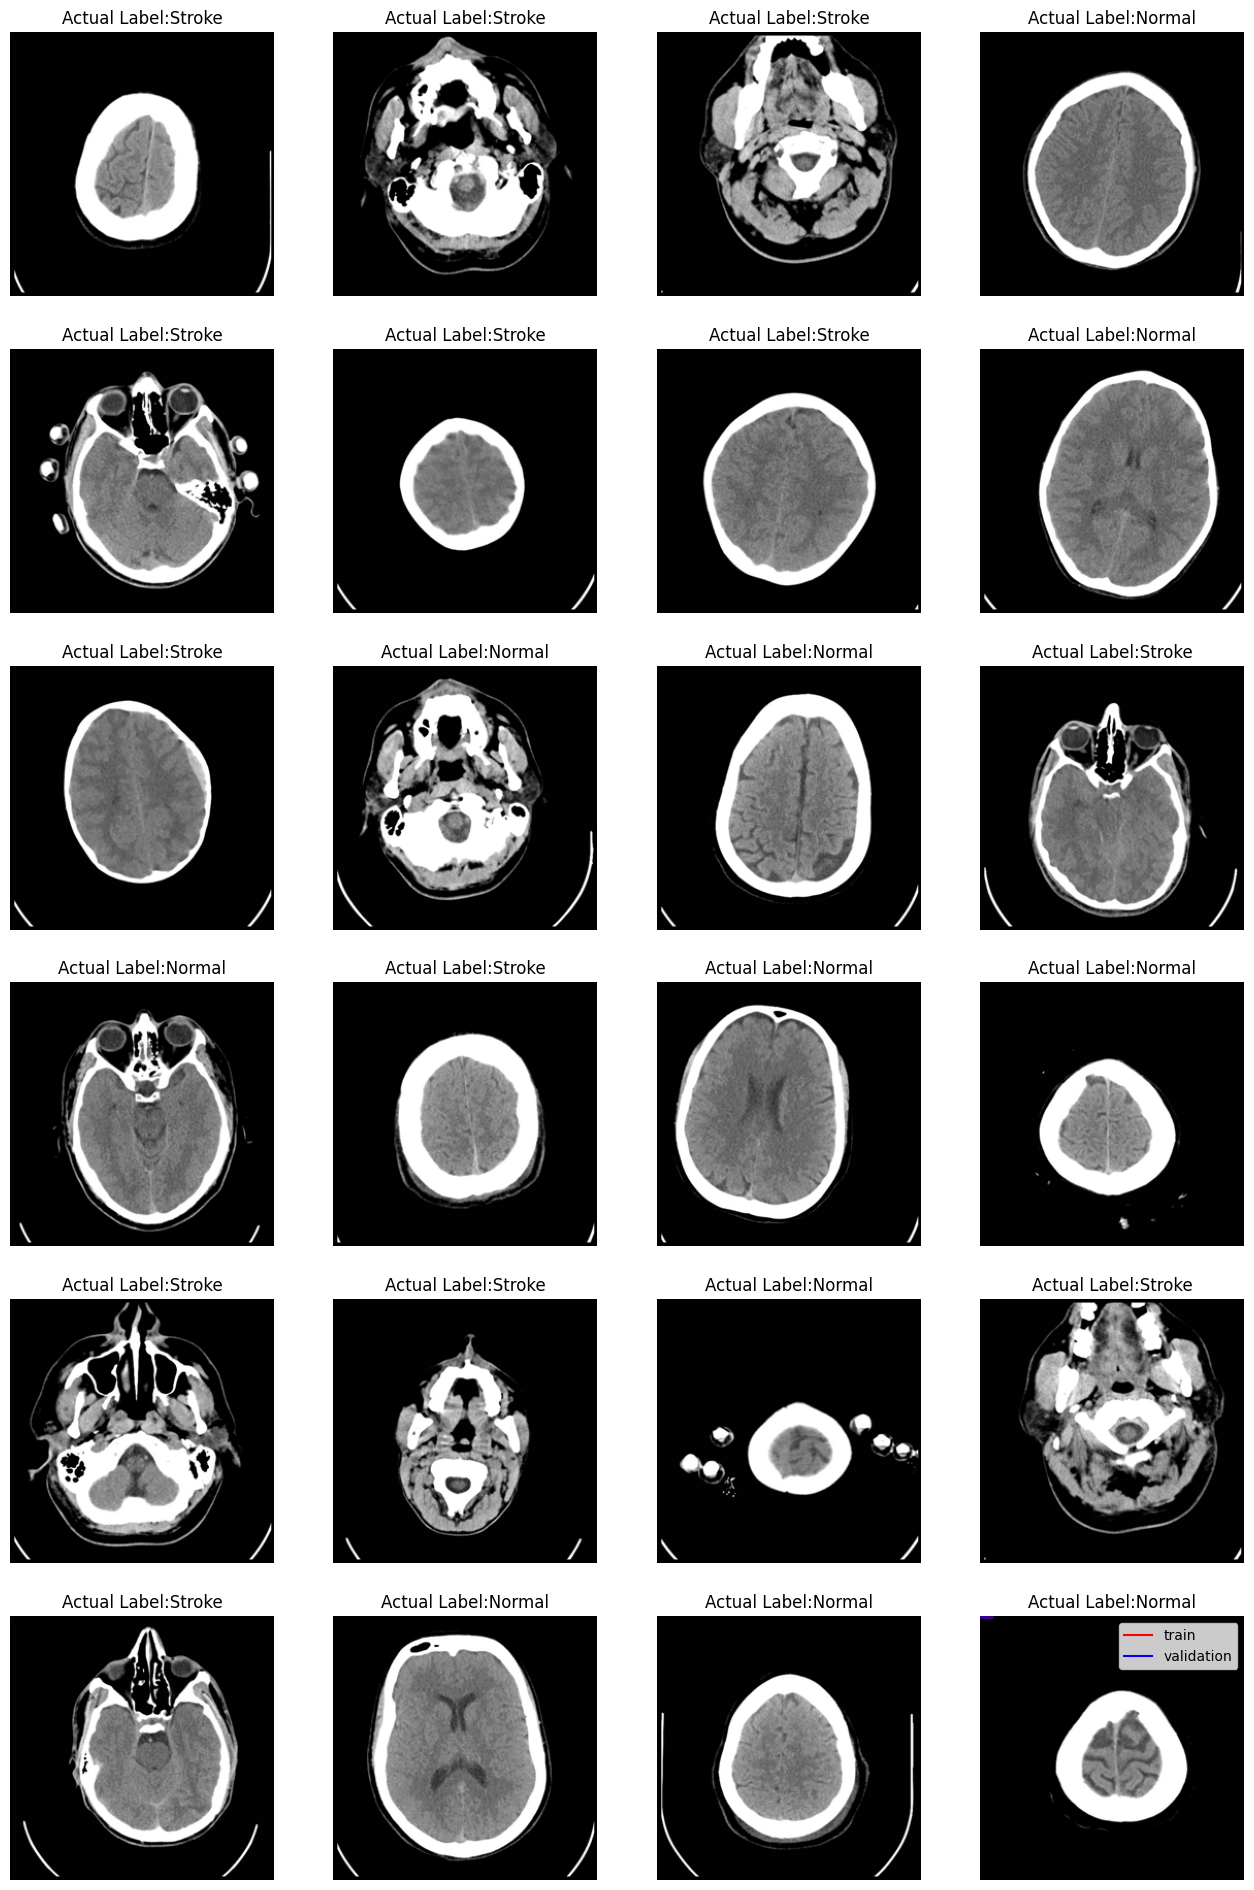

12/12 [==============================] - 20s 2s/step
Actual Label: [0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1]
Predicted Label: [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]
-----Metrics Evaluation On Test Data -----

Confusion Matrix:
 [[231   1]
 [  3 141]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       232
           1       0.99      0.98      0.99       144

    accuracy                           0.99       376
   macro avg       0.99      0.99      0.99       376
weighted avg       0.99      0.99      0.99       376

12/12 [==============================] - 19s 2s/step
ROC - Area :0.9988924808429118


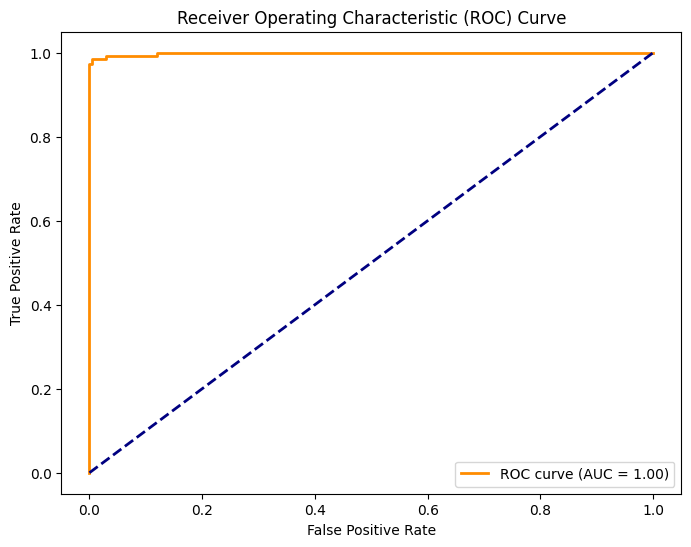

1/1 [==============================] - 0s 79ms/step
[0]


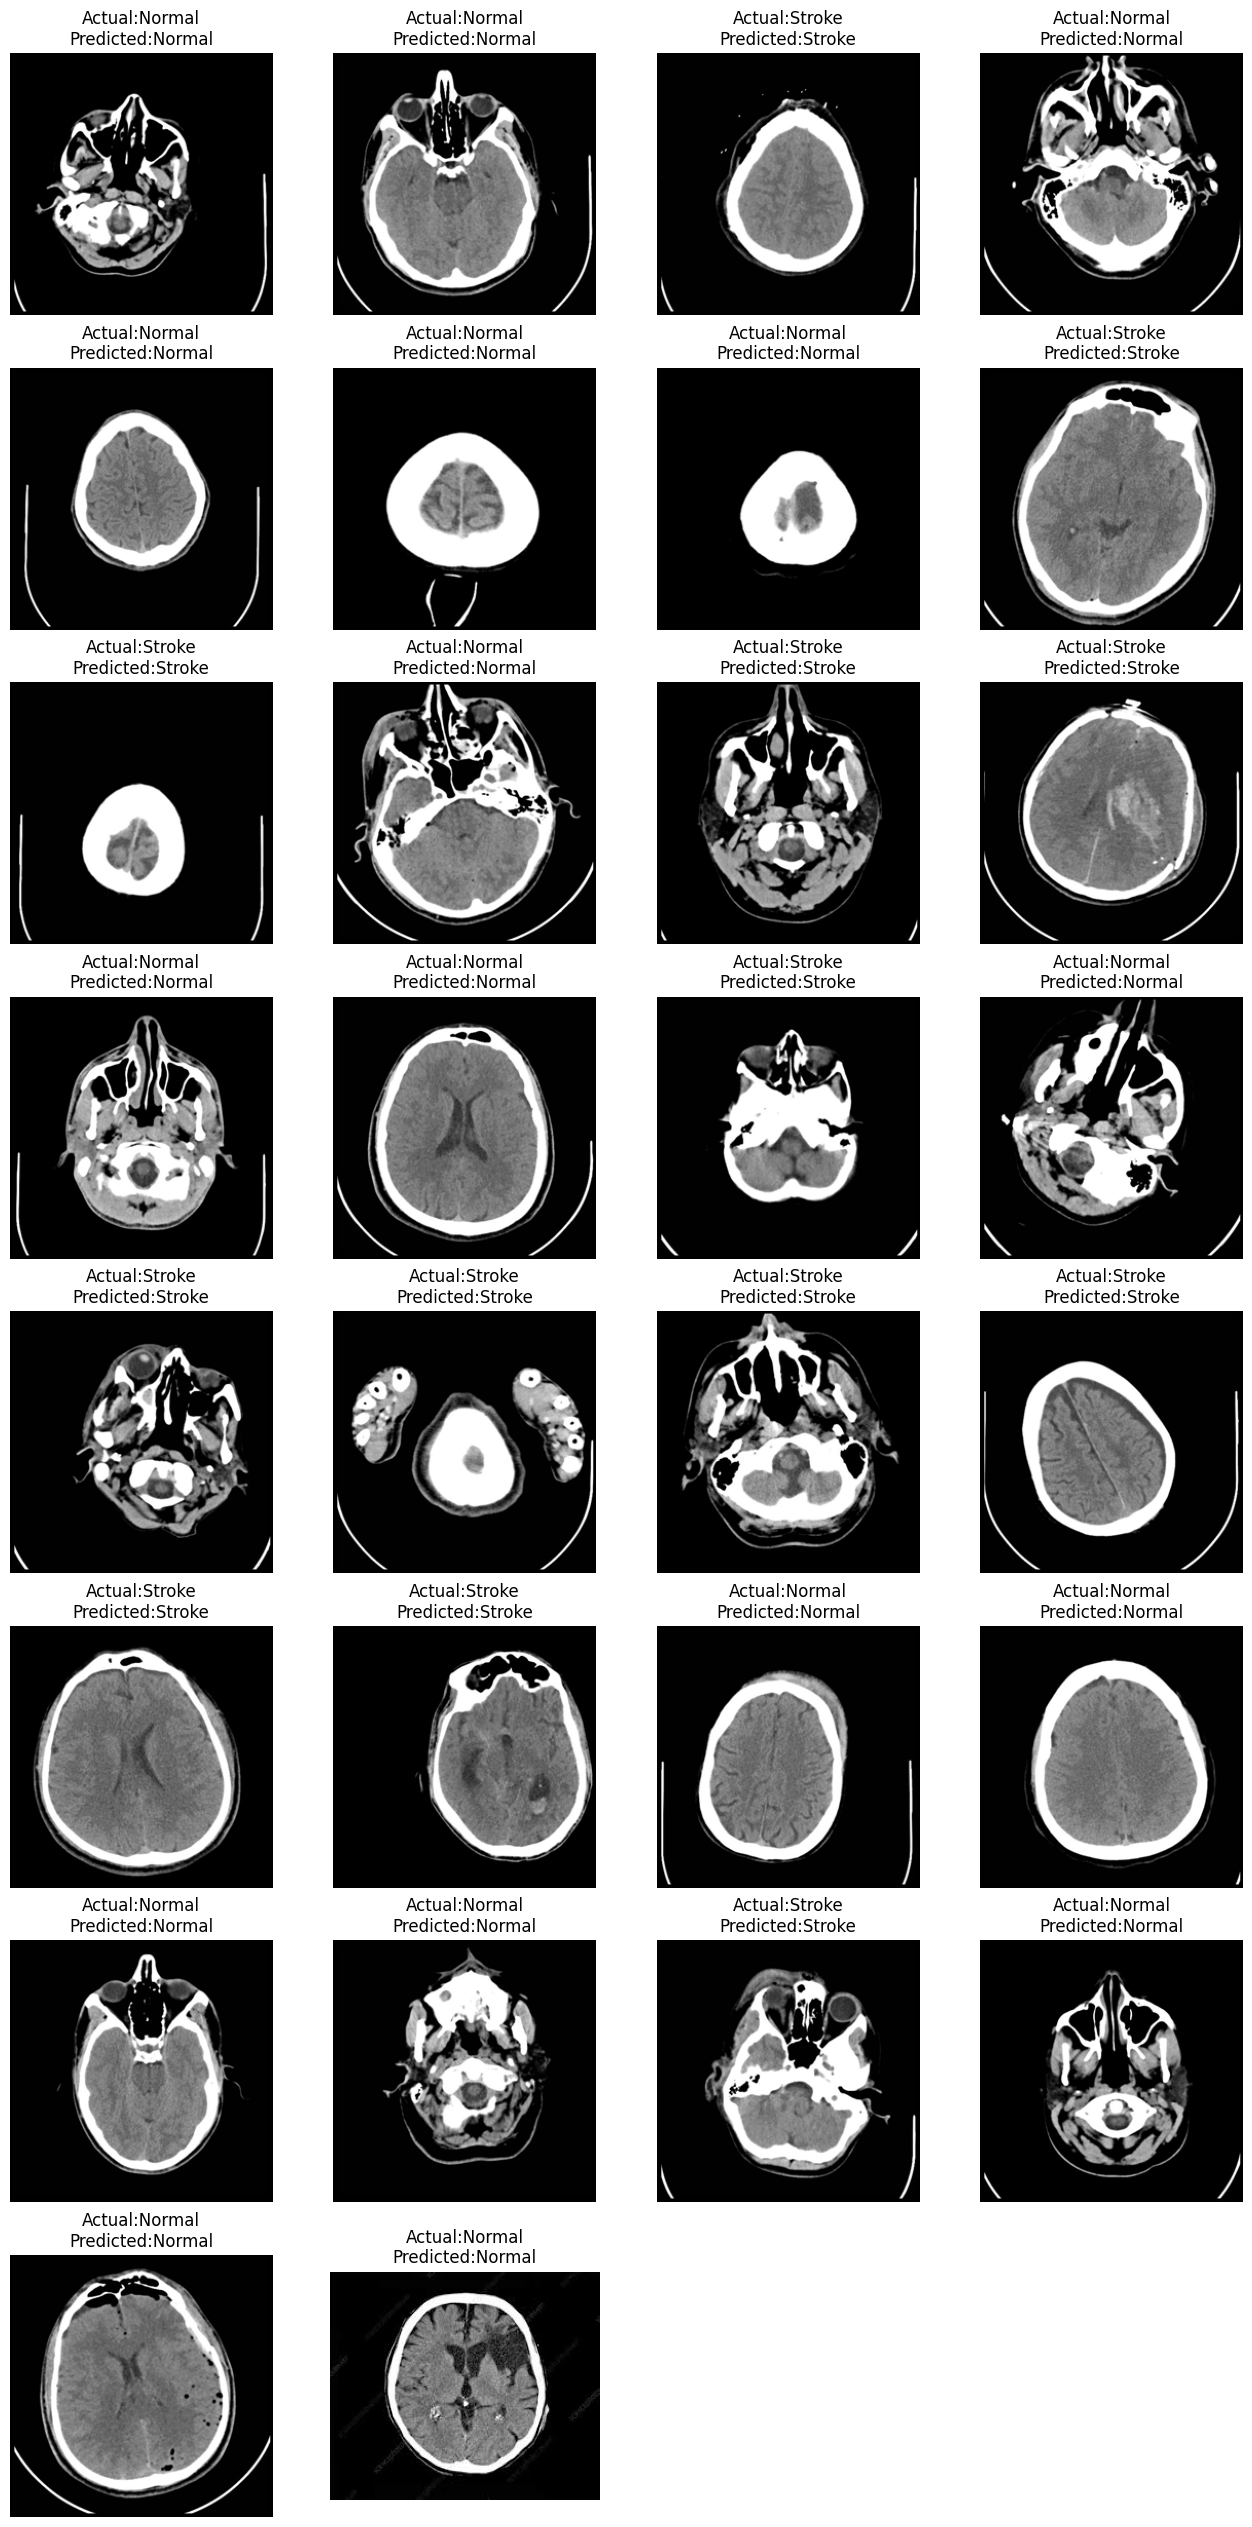

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split

import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub 

normal_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Normal"
stroke_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Stroke"

normal_folder = os.listdir(normal_path)
stroke_folder = os.listdir(stroke_path)

print("Images in Normal Data:",len(normal_folder))
print("Images in Stroke Data:",len(stroke_folder))

normal_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Normal"
stroke_path = "/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Stroke"

data = []

for img_file in normal_folder:
    image = Image.open("/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Normal/" + img_file)
    image = image.resize((256,256))
    image = image.convert('RGB')
    image = np.array(image)
    data.append(image)
    
for img_file in stroke_folder:
    image = Image.open("/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Stroke/" + img_file)
    image = image.resize((256,256))
    image = image.convert('RGB')
    image = np.array(image)
    data.append(image)
    

len(data)

data[0].shape

data[0]

normal_label = [0]*len(normal_folder)
stroke_label = [1]*len(stroke_folder)

Target_label = normal_label + stroke_label

len(Target_label)

x = np.array(data)
y = np.array(Target_label)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15,shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train_s = x_train/255
x_test_s = x_test/255

class_labels = ["Normal","Stroke"]
plt.figure(figsize=(16,24))
for i in range(24):
    plt.subplot(6,4,i+1)
    plt.imshow(x_train[i])
    plt.title(f"Actual Label:{class_labels[y_train[i]]}")
    plt.axis("off")
    
    
model = Sequential()

model.add(Conv2D(filters=100,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=80,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=500, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=500, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",
             metrics=["accuracy"])

model.summary()

history = model.fit(x_train_s,y_train,batch_size=32,
         epochs=12, validation_data=(x_test_s,y_test))

loss, acc = model.evaluate(x_test_s,y_test)
print("Loss on Test Data:",loss)
print("Accuracy on Test Data:",acc)

loss, acc = model.evaluate(x_train_s,y_train)
print("Loss on Train Data:",loss)
print("Accuracy on Train Data:",acc)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

y_pred_test = model.predict(x_test_s)
y_pred_test_label = [1 if i>=0.5 else 0 for i in y_pred_test]

print("Actual Label:",y_test[:20])
print("Predicted Label:",y_pred_test_label[:20])

print("-----Metrics Evaluation On Test Data -----")
print()
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred_test_label))
print()
print("Classification Report:\n",classification_report(y_test,y_pred_test_label))


from sklearn.metrics import roc_curve, precision_recall_curve, auc

y_prob = model.predict(x_test_s)

fpr, tpr, threshold = roc_curve(y_test, y_prob)

# Compute ROC curve and ROC area
roc_auc = auc(fpr, tpr)
print(f"ROC - Area :{roc_auc}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

class_labels = ["Normal","Stroke"]
plt.figure(figsize=(16,32))
for i in range(30):
    plt.subplot(8,4,i+1)
    plt.imshow(x_test[i])
    plt.title(f"Actual:{class_labels[y_test[i]]}\nPredicted:{class_labels[y_pred_test_label[i]]}")
    plt.axis("off")

import cv2

test_img = cv2.imread('/kaggle/input/dawdasd/Da.jpg')

plt.imshow(test_img)

test_img = cv2.resize(test_img,(256,256))

test_input = test_img.reshape((1,256,256,3))

ans = model.predict(test_input)
y_ans = [1 if i>=0.5 else 0 for i in ans]
y_ans

test_img = cv2.resize(test_img,(256,256))

test_input = test_img.reshape((1,256,256,3))

ans = model.predict(test_input)
y_ans = [1 if i>=0.5 else 0 for i in ans]
print(y_ans)